In [2]:
from keras.utils import normalize
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from PIL import Image
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
from unet import unet_model
import random
from pathlib import Path
import logging
import itertools
import re

LOGGER = logging.getLogger()
from datetime import datetime

from skimage.morphology import binary_erosion
from skimage.morphology import skeletonize
from skimage.filters import hessian
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.color import label2rgb

# TopoStats needs to be >= version 2.1.0
# from topostats import io
# from topostats import grain_finding_cats_unet

import tensorflow as tf
from sklearn.model_selection import train_test_split

for key, value in os.environ.items():
    print(f"{key} : {value}")

CHROME_DESKTOP : code-url-handler.desktop
DBUS_SESSION_BUS_ADDRESS : unix:path=/run/user/1000/bus
DEFAULTS_PATH : /usr/share/gconf/pop.default.path
DESKTOP_SESSION : pop
DISPLAY : :1
ELECTRON_NO_ATTACH_CONSOLE : 1
GDK_BACKEND : x11
GDMSESSION : pop
GIO_LAUNCHED_DESKTOP_FILE : /usr/share/applications/gitkraken.desktop
GIO_LAUNCHED_DESKTOP_FILE_PID : 5989
GJS_DEBUG_OUTPUT : stderr
GJS_DEBUG_TOPICS : JS ERROR;JS LOG
GNOME_DESKTOP_SESSION_ID : this-is-deprecated
GNOME_SHELL_SESSION_MODE : pop
GPG_AGENT_INFO : /run/user/1000/gnupg/S.gpg-agent:0:1
GTK_IM_MODULE : ibus
GTK_MODULES : gail:atk-bridge
HOME : /home/sylvia
INVOCATION_ID : 318d3128bc4f4aeab97aa4c2f4b66649
JOURNAL_STREAM : 8:38556
LANG : en_US.UTF-8
LOGNAME : sylvia
MANAGERPID : 2624
MANDATORY_PATH : /usr/share/gconf/pop.mandatory.path
ORIGINAL_XDG_CURRENT_DESKTOP : Unity
PATH : /home/sylvia/anaconda3/envs/car-or-truck-p9/bin:/home/sylvia/anaconda3/condabin:/home/sylvia/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/s

In [3]:
# Ensure that your GPU is working
tf.test.gpu_device_name()

2023-10-11 20:10:43.724728: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 20:10:43.738857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-11 20:10:43.742781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-11 20:10:43.742925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

'/device:GPU:0'

In [4]:
# Set the random seeds
SEED = 0
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [10]:
# ORIGINAL_IMAGE_DIR = Path("/Users/sylvi/topo_data/cats/training_data/images_flattened_all/")
# MASK_DIR = Path("/Users/sylvi/topo_data/cats/training_data/images_edge_detection_upper_labels_multiclass_sigma_4")

# Linux
ORIGINAL_IMAGE_DIR = Path("/home/sylvia/cats_data/images_flattened_all/")
MASK_DIR = Path("/home/sylvia/cats_data/images_edge_detection_upper_labels_sigma_4/")

MODEL_SAVE_DIR = Path("./saved_models")
CHANNELS = 1

BATCH_SIZE = 4

# Get the number of .png images
NUM_IMAGES = len(list(ORIGINAL_IMAGE_DIR.glob("*.png")))
print(f"Number of images: {NUM_IMAGES}")

Number of images: 44


In [18]:
# An image generator that loads images as they are needed
def image_generator(image_indexes, batch_size=4):
    while True:
        # Select files (paths/indices) for the batch
        batch_image_indexes = np.random.choice(a=image_indexes, size=batch_size)
        batch_input = []
        batch_output = []

        # Load the image and ground truth
        for index in batch_image_indexes:
            # Find the index as the only number in the filename
            # index = re.search(r"\d+", image_path)
            # print(index)
            image = cv2.imread(str(ORIGINAL_IMAGE_DIR / f"training_image_{index}.png"), 0)
            image = Image.fromarray(image)
            image = image.resize((512, 512))
            image = np.array(image)
            # Normalise the image
            image = image - np.min(image)
            image = image / np.max(image)

            # ground_truth = np.load(MASK_DIR / f"mask_array_{index}.npy")
            ground_truth = cv2.imread(str(MASK_DIR / f"mask_{index}.png"), 0)
            ground_truth = Image.fromarray(ground_truth)
            ground_truth = np.array(ground_truth)
            ground_truth = ground_truth.astype(bool)
            ground_truth = Image.fromarray(ground_truth.astype(np.uint8))
            ground_truth = ground_truth.resize((512, 512))
            ground_truth = np.array(ground_truth).astype(int)

            # Augment the images
            # Flip the images 50% of the time
            if random.choice([0, 1]) == 1:
                image = np.flip(image, axis=1)
                ground_truth = np.flip(ground_truth, axis=1)
            # Rotate the images by either 0, 90, 180, or 270 degrees
            rotation = random.choice([0, 1, 2, 3])
            image = np.rot90(image, rotation)
            ground_truth = np.rot90(ground_truth, rotation)

            batch_input.append(image)
            batch_output.append(ground_truth)

        batch_x = np.array(batch_input).astype(np.float32)
        batch_y = np.array(batch_output).astype(np.float32)

        yield (batch_x, batch_y)

image shape: (512, 512)
image max: 1.0
image min: 0.0


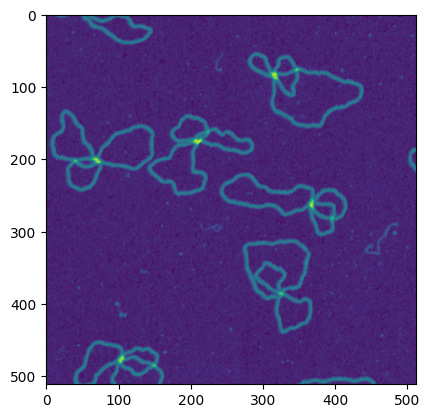

mask shape: (512, 512)
mask unique: [0. 1.]


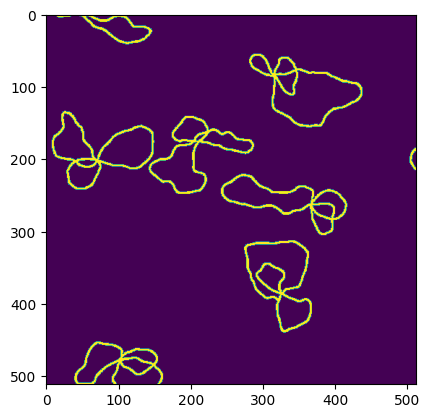

mask dtype: float32
image shape: (512, 512)
image max: 1.0
image min: 0.0


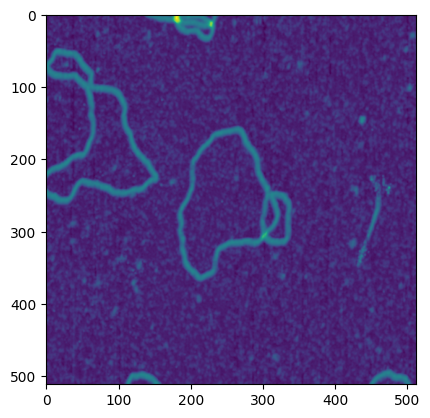

mask shape: (512, 512)
mask unique: [0. 1.]


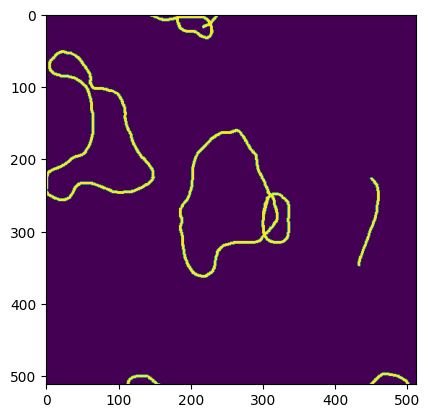

mask dtype: float32
image shape: (512, 512)
image max: 1.0
image min: 0.0


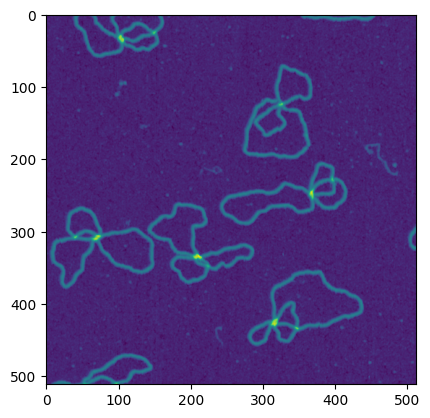

mask shape: (512, 512)
mask unique: [0. 1.]


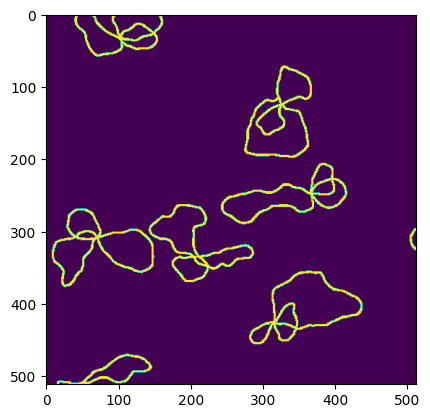

mask dtype: float32
image shape: (512, 512)
image max: 1.0
image min: 0.0


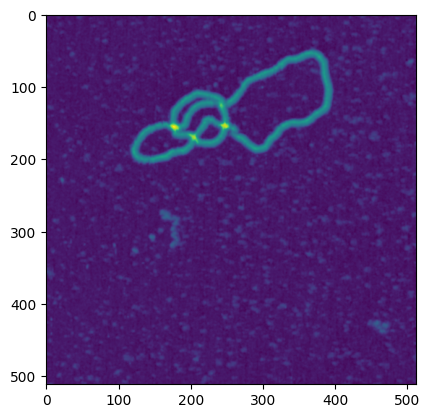

mask shape: (512, 512)
mask unique: [0. 1.]


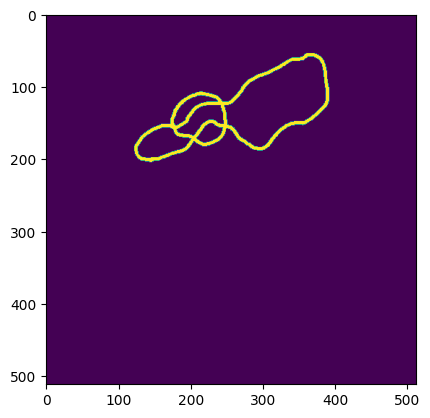

mask dtype: float32


In [19]:
# Check that the generator is doing the right thing
batch_generator = image_generator([0, 1, 2, 3, 4], batch_size=4)
(batch_x, batch_y) = next(batch_generator)
for image, mask in zip(batch_x, batch_y):
    plt.imshow(image)
    print(f"image shape: {image.shape}")
    print(f"image max: {np.max(image)}")
    print(f"image min: {np.min(image)}")
    plt.show()
    plt.imshow(mask)
    print(f"mask shape: {mask.shape}")
    print(f"mask unique: {np.unique(mask)}")
    plt.show()

    print(f"mask dtype: {mask.dtype}")

In [20]:
# Split what images are used for training and validation
train_image_indexes, validation_image_indexes = train_test_split(range(0, NUM_IMAGES), test_size=0.2, random_state=SEED)

print(f"Number of training images: {len(train_image_indexes)}")
print(f"Number of validation images: {len(validation_image_indexes)}")

print(f"Training image indexes: {train_image_indexes}")
print(f"Validation image indexes: {validation_image_indexes}")

# Create the generators
train_generator = image_generator(train_image_indexes, batch_size=4)
validation_generator = image_generator(validation_image_indexes, batch_size=4)

Number of training images: 35
Number of validation images: 9
Training image indexes: [31, 29, 20, 41, 2, 43, 18, 15, 22, 16, 40, 8, 13, 5, 17, 32, 14, 35, 7, 34, 1, 26, 12, 33, 24, 6, 23, 36, 21, 19, 9, 39, 42, 3, 0]
Validation image indexes: [30, 37, 27, 4, 10, 25, 28, 11, 38]


In [21]:
# Get the model
model = unet_model(IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=CHANNELS)
# model.summary()

2023-10-11 20:17:35.862772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-11 20:17:35.862947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-11 20:17:35.863053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-11 20:17:35.863298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-11 20:17:35.863413: I tensorflow/compiler/xla/stream_executo

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [22]:
EPOCHS = 50
history = model.fit_generator(
    train_generator,
    # How many steps (batches of samples) to draw from generator before declaring one epoch finished and starting the next epoch
    steps_per_epoch=NUM_IMAGES // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    # How many steps (batches) to yield from validation generator at the end of every epoch
    validation_steps=NUM_IMAGES // BATCH_SIZE,
    verbose=1,
)

Epoch 1/50


/tmp/ipykernel_13544/4062814745.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2023-10-11 20:17:44.953215: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-11 20:17:45.387223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800
2023-10-11 20:17:46.637773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-11 20:17:47.208512: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f11c613e2c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-11 20:17:47.208532: I ten

11/11 [==============================] - 11s 303ms/step - loss: 0.3752 - accuracy: 0.9220 - val_loss: 0.3786 - val_accuracy: 0.9698
Epoch 2/50
11/11 [==============================] - 3s 272ms/step - loss: 0.2181 - accuracy: 0.9644 - val_loss: 0.2941 - val_accuracy: 0.9675
Epoch 3/50
11/11 [==============================] - 3s 283ms/step - loss: 0.1615 - accuracy: 0.9639 - val_loss: 0.2574 - val_accuracy: 0.9692
Epoch 4/50
11/11 [==============================] - 3s 275ms/step - loss: 0.1144 - accuracy: 0.9616 - val_loss: 0.0733 - val_accuracy: 0.9693
Epoch 5/50
11/11 [==============================] - 3s 290ms/step - loss: 0.0715 - accuracy: 0.9654 - val_loss: 0.0622 - val_accuracy: 0.9649
Epoch 6/50
11/11 [==============================] - 3s 255ms/step - loss: 0.0629 - accuracy: 0.9626 - val_loss: 0.0426 - val_accuracy: 0.9708
Epoch 7/50
11/11 [==============================] - 3s 282ms/step - loss: 0.0692 - accuracy: 0.9625 - val_loss: 0.0479 - val_accuracy: 0.9673
Epoch 8/50
11/11

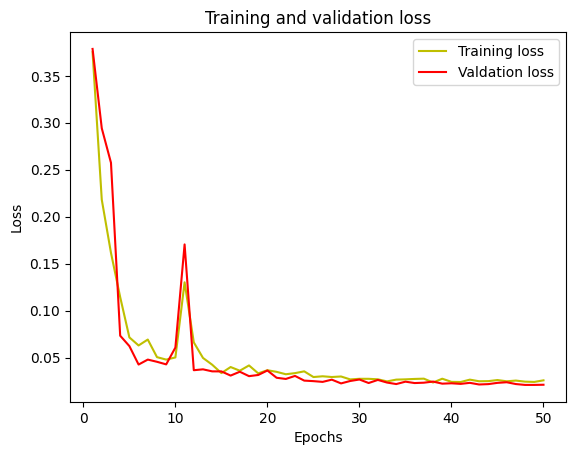

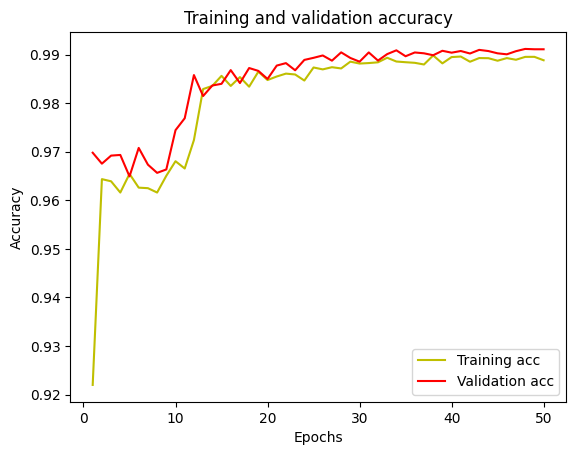

In [23]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Valdation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.plot(epochs, acc, "y", label="Training acc")
plt.plot(epochs, val_acc, "r", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()